In [23]:
# data cleaning to remove invalid cut actions
import json
trajs = json.load(open('trajectories/graphs.json'))

HeteroData(
  0={ x=[2] },
  1={ x=[1] },
  2={ x=[3] },
  3={ x=[1] },
  (1, 0, 2)={
    edge_index=[2, 2],
    edge_attr=[2],
  },
  (2, 1, 3)={
    edge_index=[2, 1],
    edge_attr=[1],
  },
  (0, 2, 1)={
    edge_index=[2, 3],
    edge_attr=[3],
  }
)


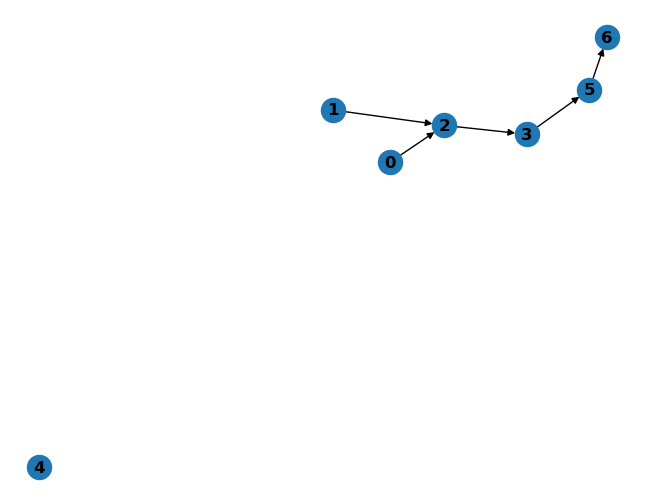

In [ ]:
import torch
import networkx as nx
from torch_geometric.data import Data, HeteroData
from torch_geometric.utils import to_networkx   

x = torch.tensor([0,0,1,2,2,2,3])
edge_index = torch.tensor([[0,2], [2,3], [4,5], [5,6], [1,6], [1,6]]).T
edge_attr = torch.tensor([2,0,0,1,2,2])

data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)


edge_type = edge_attr
node_type = x

het_data = data.to_heterogeneous(node_type, edge_type)
print(het_data)

nx.draw(to_networkx(het_data), with_labels=True, font_weight='bold')

In [ ]:
def show_pyg_graph(graph):

    # Create an empty NetworkX directed graph
    G = nx.DiGraph()
    
    # Add nodes with their features
    for i in range(graph.num_nodes):
        G.add_node(i, label=NODES[graph.x[i].item()])
    
    # Add edges with their attributes
    edge_index = graph.edge_index
    edge_attr = graph.edge_attr if 'edge_attr' in graph else None
    for i in range(edge_index.size(1)):
        source, target = edge_index[:, i].tolist()
        if edge_attr is not None:
            label = RELS[int(edge_attr[i].item())]
            G.add_edge(source, target, label=label)
        else:
            G.add_edge(source, target)
    
    # Draw the graph
    pos = nx.circular_layout(G)
    labels = nx.get_node_attributes(G, 'label')
    edge_labels = nx.get_edge_attributes(G, 'label')
    
    nx.draw(G, pos, with_labels=True, labels=labels, node_color='lightblue', node_size=500, font_size=10, font_color='black', font_weight='bold', arrows=True)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

#show_pyg_graph(data)

In [ ]:
for i,traj in enumerate(trajs):
    for graph in traj:
        triples = {tuple(triple) for triple in graph}
        #if ['player', 'verb', 'cut'] in graph and ['tomato', 'is', 'sliced'] in graph:
        if ('player', 'verb', 'cut') in triples and ('tomato', 'is', 'sliced') in triples:
            trajs[i] = []
new_trajs = []
for traj in trajs:
    if traj:
        new_trajs.append(traj)

print(len(trajs), len(new_trajs))

fname = 'trajectories/graphs.json'
#json.dump(new_trajs, open(fname, 'w'))

In [ ]:
len(trajs)

41

In [29]:
for i,traj in enumerate(trajs):
    for j,graph in enumerate(traj):
        trajs[i][j]['edges'][0] = [0,1,1]

json.dump(trajs, open(fname, 'w'))  

In [28]:
for i,traj in enumerate(trajs):
    for j,graph in enumerate(traj):
        print(graph['edges'][0])

[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]
[0, 1, 1]


In [8]:
#generate a random split
import json
import random
with open('data/trajectories.json') as f:
    trajs = json.load(f)

graphs = [graph for traj in trajs for graph in traj] #flatten graphs

idxs = list(range(len(graphs)))
test_idxs = random.sample(idxs, 100)
train_idxs = [idx for idx in idxs if idx not in test_idxs]

split = {'train': train_idxs, 'test': test_idxs}

json.dump(split, open('data/graph_split.json', 'w'))

#print(split['test'])
graphs = [graphs[i] for i in split['test']]
len(graphs)

100

In [8]:
from data.dataset import ToyDataset

dataset = ToyDataset('data', mode='graph', split=None)
len(dataset)

actions = set()
for i in range(len(dataset)):
    actions.add((dataset[i].y.item(), dataset[i].w.item()))

actions

{(0, 5), (1, 7), (1, 8), (2, 8), (3, 7), (3, 8)}

In [1]:
from data.dataset import ToyDataset

dataset = ToyDataset('data', mode='graph', split=None)
len(dataset)

for i in range(len(dataset)):
    print(dataset[i].w.item())

<frozen importlib._bootstrap>:228: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


pygame 2.6.1 (SDL 2.30.7, Python 3.9.20)
Hello from the pygame community. https://www.pygame.org/contribute.html
0
0
1
0
4
1
0
0
3
0
4
0
0
0
0
0
1
0
4
0
0
0
0
0
0
2
5
0
0
1
0
0
4
0
0
0
0
2
0
5
0
0
0
1
0
3
0
4
0
0
1
3
0
0
4
0
0
0
2
0
0
5
0
1
0
4
2
0
0
5
1
0
0
3
0
4
0
2
5
0
0
1
0
0
0
0
0
3
4
2
0
0
0
0
0
0
0
5
0
1
0
0
0
4
0
0
0
0
1
0
0
0
0
0
4
0
2
0
0
0
0
5
0
1
0
3
0
4
0
0
1
0
0
0
4
1
0
4
1
0
4
0
1
0
0
0
4
0
0
0
0
2
0
5
0
0
0
1
0
0
0
0
4
0
0
0
0
0
2
0
0
5
0
0
0
1
0
3
0
0
4
0
0
1
0
3
0
4
0
2
0
5
0
0
1
0
4
0
2
0
5
1
3
0
0
0
2
0
0
0
5
1
3
4
2
0
0
0
0
5
2
0
5
0
1
0
3
4
0
0
2
0
0
0
5
1
3
1
0
0
0
0
3
4
0
0
0
0
2
0
0
0
5
1
3
0
4
0
0
0
2
0
0
0
1
0
0
0
0
3
4
2
0
5
0
0
2
0
5
1
0
4
0
0
1
0
4
1
4
2
5
1
4
0
2
0
5
0
0
1
0
0
3
4
0
1
0
0
2
5
1
3
4
2
5
1
4
2
5
2
5
2
5
2
5
2
5
2
5
2
5
0
0
0
2
0
0
0
0
5
0
0
2
0
0
5
2
0
1
0
1
0
0
0
0
0
0
4
2
5
1
3
4
0
0
0
0
2
0
0
5
1
0
0
3
4
2
0
5
0
0
0
2
0
0
5
1
3
4
0
0
2
0
0
0
0
0
5
1
3
4
0
0
2
0
0
5
1
4
2
5
0
0
0
0
2
5
1
4
2
5
1
4
1
3
4
2
5
2
0
1
3
0
4
0
2
0
0
5
0
1
0
4
0